In [19]:
# 匯入自定義模組
import ITSA.simulation as sim
from ITSA.models.AIRMA import AIRMA
from ITSA.stattools import interval_correlation
from ITSA.itsaplots import plot_acf, plot_pacf, dandelion, segment
from ITSA.utils import refactor_interval

# 匯入第三方模組
import numpy as np
import pandas as pd
import ipywidgets as widgets

import plotly.graph_objects as go

In [20]:
def plot_interval_ts(interval_ts, title="Simulation Result"):
    lags = np.arange(interval_ts.shape[0])

    fig = go.FigureWidget()
    fig.add_trace(
        go.Scatter(
            x=lags,
            y=interval_ts["Upper Bound"],
            mode="lines+markers",
            line=dict(color="rgb(70,130,180)", width=1),
            name="Simulated Upper Bound",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=lags,
            y=interval_ts["Lower Bound"],
            mode="lines+markers",
            line=dict(color="rgb(205,38,38)", width=1),
            name="Simulated Lower Bound",
        )
    )
    fig.update_layout(
        title=title,
        xaxis_title="Lag",
        yaxis_title="Value",
        hovermode="x",
    )
    return(fig)

## 模型演示

本小節使用`ipywidgets`，以互動化的方式，呈現不同參數設定對模型趨勢的影響。


In [21]:
def show_air_1(params, sigma, lags):
    sim_data = sim.air([params], sigma, 1000, lags)
    res = plot_interval_ts(sim_data, "Simulation of AIR(1)")
    display(res)

widgets.interactive(
    show_air_1,
    params=widgets.FloatSlider(value=-0.5, min=-0.9, max=0.9, step=0.2),
    sigma=widgets.FloatSlider(value=1, min=1, max=10, step=1),
    lags=widgets.IntSlider(min=200, max=1000, step=100),
)

interactive(children=(FloatSlider(value=-0.5, description='params', max=0.9, min=-0.9, step=0.2), FloatSlider(…

In [22]:
def show_ivma_1(params, sigma, lags):
    sim_data = sim.ivma([params], sigma, 1000, lags)
    res = plot_interval_ts(sim_data, "Simulation of IVMA(1)")
    display(res)

widgets.interactive(
    show_ivma_1,
    params=widgets.FloatSlider(value=-0.5, min=-0.9, max=0.9, step=0.2),
    sigma=widgets.FloatSlider(value=1, min=1, max=10, step=1),
    lags=widgets.IntSlider(min=200, max=1000, step=100),
)

interactive(children=(FloatSlider(value=-0.5, description='params', max=0.9, min=-0.9, step=0.2), FloatSlider(…

In [23]:
def show_airma_11(param_ar, param_ma, sigma, lags):
    sim_data = sim.airma([param_ar], [param_ma], sigma, 1000, lags)
    res = plot_interval_ts(sim_data, "Simulation of AIRMA(1,1)")
    display(res)

widgets.interactive(
    show_airma_11,
    param_ar=widgets.FloatSlider(value=0.3, min=-0.9, max=0.9, step=0.2),
    param_ma=widgets.FloatSlider(value=0.5, min=-0.9, max=0.9, step=0.2),
    sigma=widgets.FloatSlider(value=1, min=1, max=10, step=1),
    lags=widgets.IntSlider(min=200, max=1000, step=100),
)

interactive(children=(FloatSlider(value=0.3, description='param_ar', max=0.9, min=-0.9, step=0.2), FloatSlider…

## 模型配適
本小節以`AIRMA`模型為範例，生成模擬資料，繪製自相關函數與局部自相關函數，並配適區間值時間序列模型。

模組中，共有四種模型可供選擇，包含`AIR`、`HVAIR`、`IVMA`以及`AIRMA`模型

In [24]:
# 模擬資料生成
sim_airma11 = sim.airma(
    phi=[0.3], theta=[-0.7], sigma=1, nsamples=1000, nsimulations=250
)
sim_airma11.head()

,Upper Bound,Lower Bound
0,7.605216,-7.855100
1,7.506749,-8.053214
2,7.697391,-8.211640
3,7.578619,-7.815121
4,7.580577,-7.658686


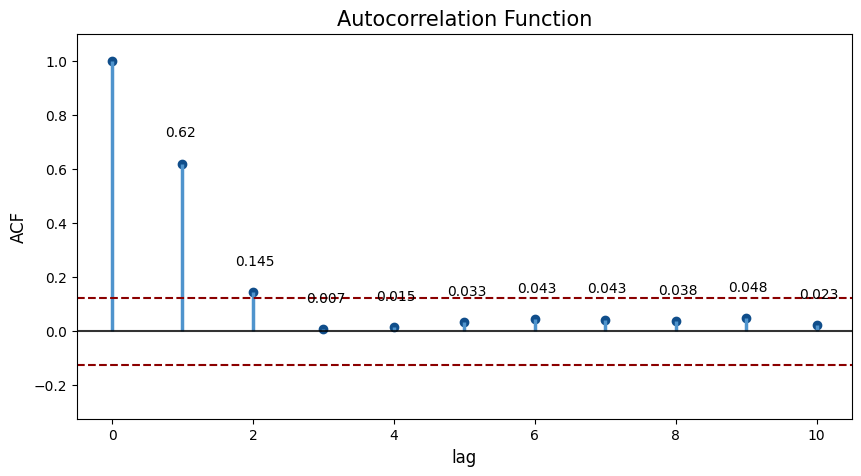

In [25]:
# 自相關函數
plot_acf(sim_airma11, n_sample=1000)

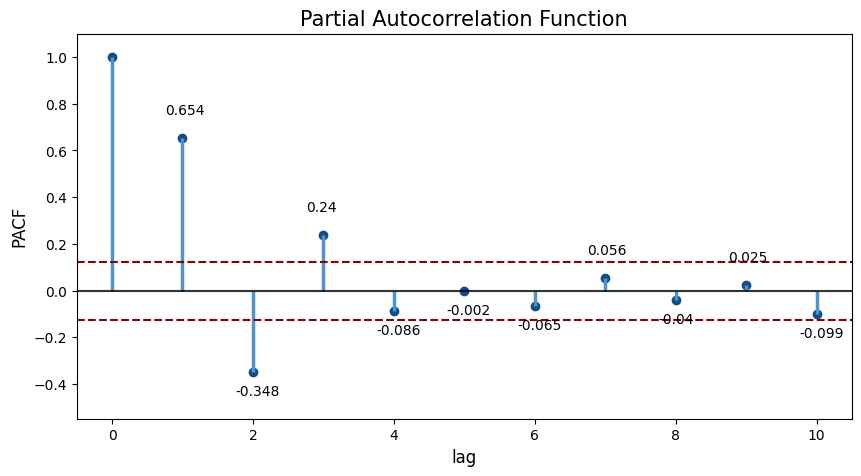

In [26]:
# 局部自相關函數
plot_pacf(sim_airma11, n_sample=1000)

In [27]:
# 模型配適
model = AIRMA(endog=sim_airma11, order=(1,1), n_sample=1000)
model.fit(iters=1000)
model

Auto-Interval-Regressive Moving Averaging Model(order=(1,1), n=250)

In [28]:
# 配適結果一覽表
model.summary()

                      AIRMA Model Results                       
Dep. Variable:    D.Upper Bound   No. Observations:      250   
                  D.Lower Bound                                
Model:              AIRMA(1, 1)   Log Likelihood:      -130.827
Method:                     mle   AIC:                  267.655
Optimizer:                  PSO   BIC:                  278.219
Date:               Jun-04-2023   HQIC:                 271.907


    Coefficients    
--------------------
ar.L1          0.346
ma.L1         -0.652
sigma          0.952


In [29]:
# 配適結果視覺化
model.fitted_check()

In [30]:
# 模型預測
model.predict(step=5)

,Upper Bound,Lower Bound
0,8.384762,-7.556041
1,7.979561,-7.692645
2,7.839274,-7.739940
3,7.790705,-7.756314
4,7.773889,-7.761983


In [31]:
# 提取配適數值
model.fitted_values().head()

,Upper Bound,Lower Bound
0,7.827028,-7.874071
1,7.564980,-7.783809
2,7.637596,-8.040510
3,7.780588,-8.031253
4,7.568716,-7.641357


In [32]:
# 提取模型殘差
model.residuals().head()

,Upper Bound,Lower Bound
0,2.850629,-3.053470
1,3.014211,-3.341846
2,3.132237,-3.243571
3,2.870473,-2.856309
4,3.084303,-3.089771


## 區間相關性視覺化
最後一小節中，我們生成高度相關的區間時間序列，並使用蒲`公英圖(dandelion plot)`與`線段圖(segment plot)`進行視覺化。

In [33]:
ts1 = sim.ivma(params=[0.5], sigma=1, nsamples=1000, nsimulations=100)

# 在ts1中心與全距資料中，參入微小的高斯雜訊，創造高相關性的ts2
randomized_ts1 = refactor_interval(ts1, standard=False) + np.random.normal(scale=0.5, size=(100, 2))
ts2 = pd.DataFrame()
ts2["Upper Bound"] = randomized_ts1["Central"] + randomized_ts1["Range"]
ts2["Lower Bound"] = randomized_ts1["Central"] - randomized_ts1["Range"]


In [34]:
values = interval_correlation(ts1, ts2)



                       Statistic Details                        
    Term       Horizontal   Vertical    Diagonal    Off_Diagonal
  Expected       1.128       1.128       1.128         1.128    
    Data         0.730       0.703       0.786         0.650    
Related corr     rho_cc      rho_rr    cross_corr    cross_corr 




In [35]:
dandelion(ts1, ts2, "ts1", "ts2")

In [36]:
segment(ts1, ts2, "ts1", "ts2")